# TSLimeExplainer For Multivariate

Advanced time series models are complex and often hard to interpret. Time Series Local Interpretable Model-agnostic Explainer (TSLime) is a model-agnostic local time series explainer. It explains a time series model behavior using an approximate linear model as surrogate. TSLime approximates model response by evaluating the model over time series samples generated by applying time series perturbation techniques. The explanation produced by TSLime is the weights of the linear model over different time point observations. The relative signed value of the explanation is indicative of model sensitivity at temporal resolution. TSLime uses the recent time context length for the local surrogate model fitting.

TSLime supports univariate and multi-variate use cases related to forecasting, time series classification, regression and anomaly detection. This notebook demonstrates usage of TSLimeExplainer for Multi-variate data using [Jena Climate dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by Max Planck Institute for Biogeochemistry.

<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Train Forecaster](#train_forecaster)
- [Initialize TSLimeExplainer](#initialize_tslime)
- [Compute Explanation](#compute_explanation)
- [Plot Explanation](#plot_explanation)

<a id='imports'></a>
### Imports

The example model is a pre-trained keras model and hosted on huggingface hub. So, this notebook requires to install tensorflow 2.4+ and huggingface_hub packages.

In [ ]:
!pip install huggingface_hub

In [1]:
import os
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from huggingface_hub import from_pretrained_keras
from aix360.datasets import ClimateDataset
from aix360.algorithms.tsutils.tsframe import tsFrame
from aix360.algorithms.tslime.tslime import TSLimeExplainer
from aix360.algorithms.tsutils.model_wrappers import Tensor_Based_Forecaster
from huggingface_hub.utils import logging as h_logging

# huggingface hub warnings
h_logging.set_verbosity_error()

<a id='load_dataset'></a>
### Load Dataset

The dataset is weather readings recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany from 2009 to 2016. It can be obtained from [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/), [Keras examples](https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_weather_forecasting.py) or [Kaggle](https://www.kaggle.com/stytch16/jena-climate-2009-2016).

As described in the prior links, the dataset consists of 14 variables (temperature, pressure etc.) measured every 10 minutes. The data is aggregated for an hour for analysis. The pre-trained model used in this notebook, is trained on selected (7) features with 120 hours as past window and forecasts temperature after 12 hours in Celcius. More details on dataset are available in [Keras examples](https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_weather_forecasting.py)


In [2]:
datasets = ClimateDataset().load_data(return_train=False, test_start=100551)

In [3]:
df = datasets["df"]
selected_feature_columns = datasets["selected_feature_columns"]
selected_feature_names = datasets["selected_feature_names"]
sequence_length = datasets["sequence_length"]
x_test = datasets["x_test"]
y_test = datasets["y_test"]
timestamps = datasets["timestamps"]

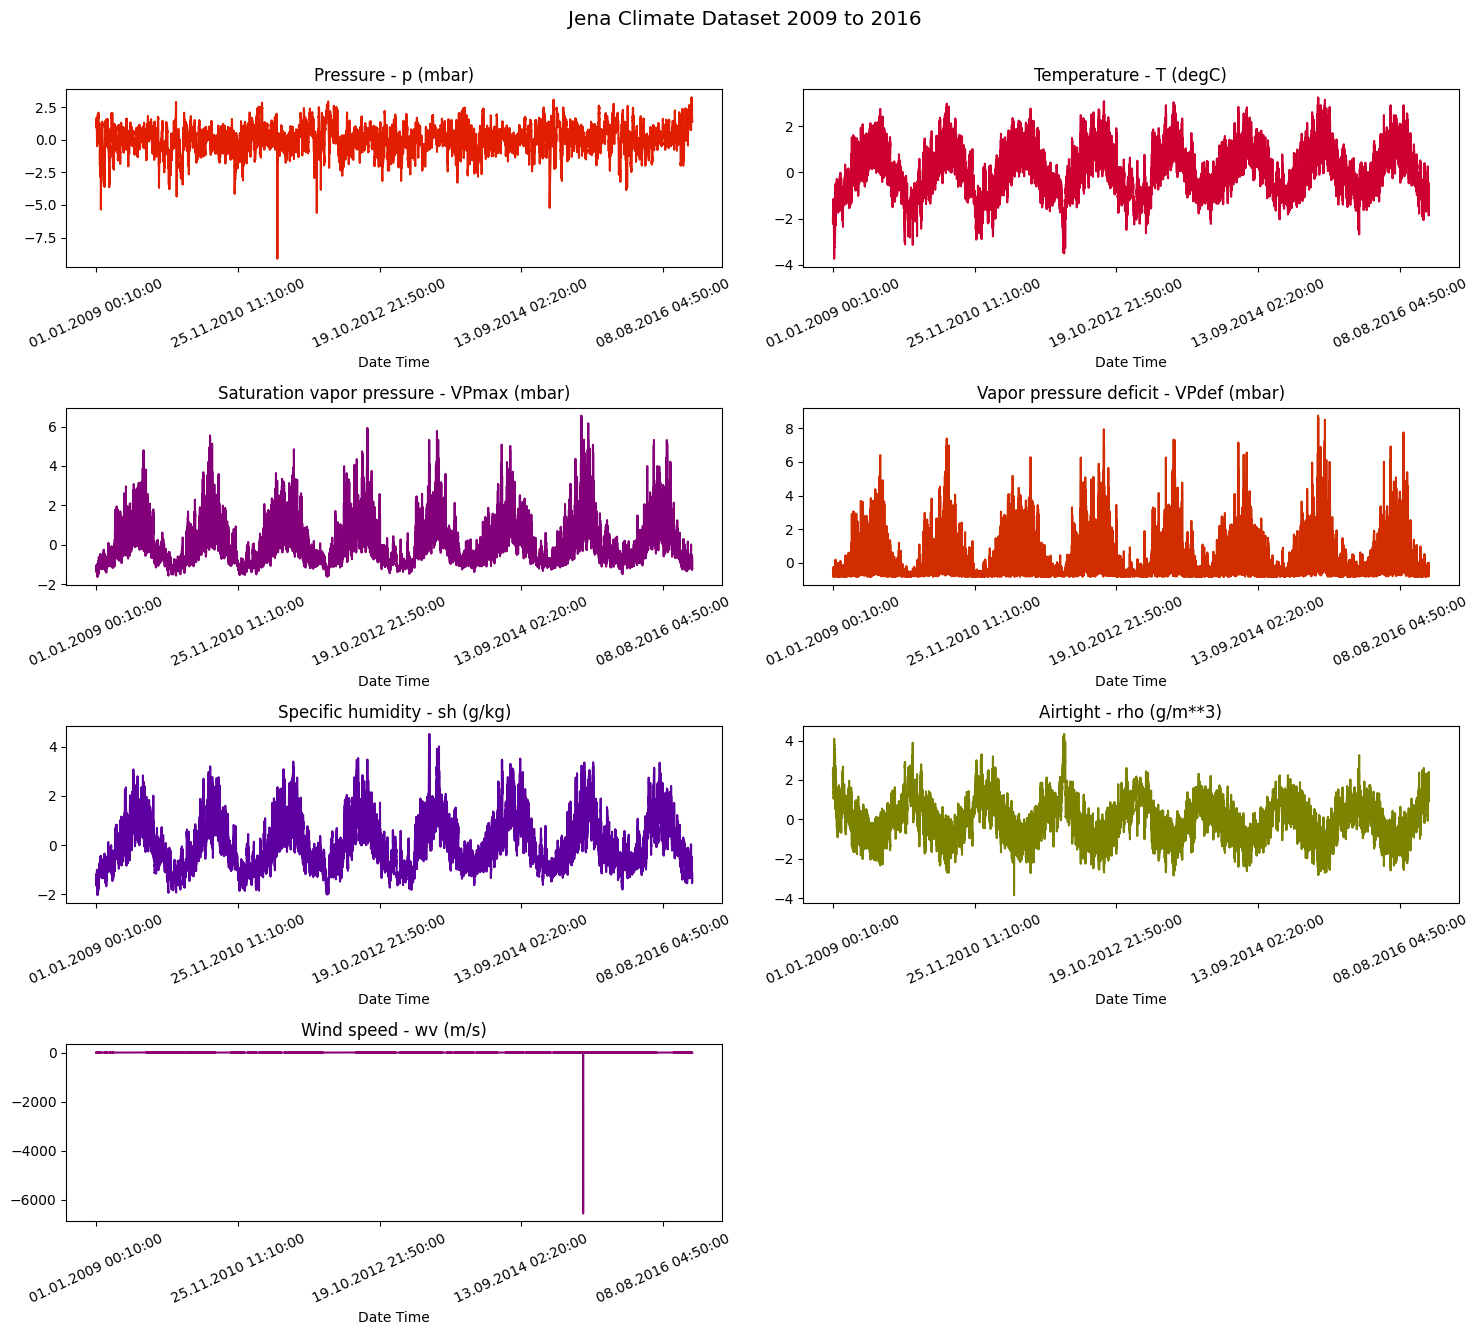

In [4]:
import matplotlib

np.random.seed(242)
cmap = matplotlib.cm.brg
colors = cmap(np.random.choice(np.arange(256), len(selected_feature_columns)))

fig = plt.figure(figsize=(15,14))

for i, feature_col in enumerate(selected_feature_columns):
    feature_data = df[feature_col]
    feature_data.index = timestamps
    ax = fig.add_subplot(int((len(selected_feature_columns) + 1) / 2), 2, i+1)
    ax = feature_data.plot(
        ax=ax,
        color=colors[i],
        title="{} - {}".format(selected_feature_names[i], feature_col),
        rot=25,
    )
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle("Jena Climate Dataset 2009 to 2016", fontsize="x-large")
plt.show()

<a id='train_forecaster'></a>
### Download Pre-Trained Model
For simplicity, use a pre-trained model from Keras/HuggingFace.

The pre-trained model is from: https://keras.io/examples/timeseries/timeseries_weather_forecasting/
The Hugging face model url is: https://huggingface.co/keras-io/timeseries_forecasting_for_weather


In [5]:
model = from_pretrained_keras("keras-io/timeseries_forecasting_for_weather")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


As the model inputs are tensor based, we are selecting Tensor_Based_Forecaster from aix360 to wrap the model. The wrapper manages the input and output shapes between the original model and the explainer.

In [7]:
f_model = Tensor_Based_Forecaster(model=model, forecast_function="predict", input_length=sequence_length, n_features = len(selected_feature_columns))

Model accuracy for selected test samples.

In [8]:
from sklearn.metrics import mean_absolute_percentage_error

test_sample_size = 10
y_pred = f_model.predict(x_test[0:test_sample_size], verbose = 0)
print("MAPE for {} samples: {}.".format(test_sample_size, mean_absolute_percentage_error(y_test[0:test_sample_size], y_pred)))

MAPE for 10 samples: 0.19223103294346963.


<a id='initialize_tslime'></a>
### Initialize TSLimeExplainer

`TSLimeExplainer` requires a model function which is to be explained and input (history) length used for the input model. The explanation is for selected latest window of length `relevant_history` over all input features. If `input_length=20` and `relevant_history=10`, explanation is computed for last 10 time points. The default linear model used for explanation is sklearn's LinearRegression. If a different linear interpretable model is to be used, the model can be wrapped with `aix360.algorithms.tslime.surrogate.LinearSurrogateModel` and provided as param `local_interpretable_model`. 

The explainer uses TSPerturber for generating perturbed/simulated time series data to train the linear interpretable model. Available perturbers are "block-bootstrap", "frequency", "moving_average", "shift". 

In [9]:
import functools
from aix360.algorithms.tslime.tslime import TSLimeExplainer
from aix360.algorithms.tsutils.tsperturbers import BlockBootstrapPerturber

relevant_history = 40
explainer = TSLimeExplainer(
                            model= functools.partial(f_model.predict, verbose = 0),
                            input_length=sequence_length,
                            relevant_history=relevant_history,
                            perturbers=[
                                BlockBootstrapPerturber(window_length=min(10, sequence_length-1), block_length=2, block_swap=2),
                            ],
                            n_perturbations=10000,
                            random_seed=22,
                        )


<a id='compute_explanation'></a>
### Compute Explanation

Compute lime weights for a given input timeseries.

In [10]:
indx = 0
instance = x_test[indx]
base_value = np.mean(instance, axis=0)

ts_instance = tsFrame(instance)
ts_instance.index = pd.to_numeric(ts_instance.index)
ts_instance

,X_1,X_2,X_3,X_4,X_5,X_6,X_7
time,,,,,,,
0,0.097410,1.087409,1.049267,1.343109,0.373339,-0.980914,-0.615123
1,0.101056,0.898643,0.775765,0.883069,0.399370,-0.819606,-1.269978
2,0.138732,0.733038,0.555661,0.504212,0.429120,-0.668334,-1.053876
3,0.160609,0.804839,0.648130,0.664498,0.414245,-0.724878,-0.431764
4,0.161824,0.675134,0.482727,0.370988,0.447714,-0.613259,0.072475
...,...,...,...,...,...,...,...
115,0.374511,1.261121,1.322769,1.840618,0.302682,-1.058753,1.519705
116,0.432848,1.161526,1.163877,1.590822,0.295244,-0.960108,0.963078
117,0.458371,1.211323,1.242020,1.428455,0.618778,-1.011511,0.426097


Explanation object `explanation` contains the history weights computed for selected time window (relevant history) and surrogate prediction for this selected time window.

In [11]:
explanation = explainer.explain_instance(ts_instance)

<a id='plot_explanation'></a>
### Plot Explanation

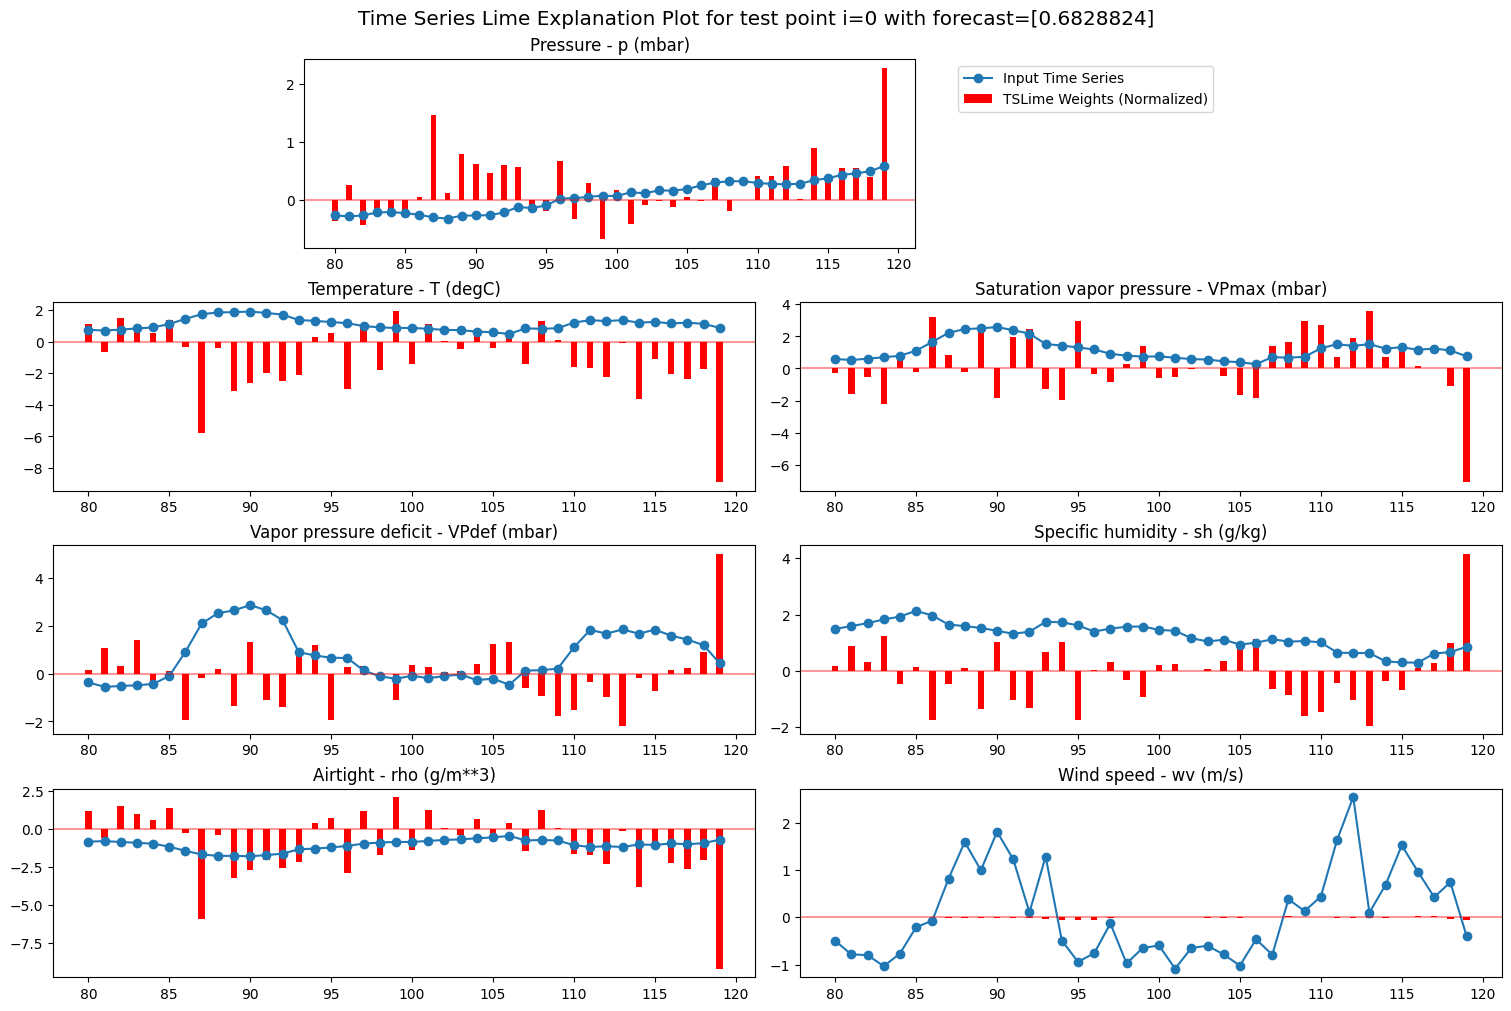

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(layout='constrained', figsize=(15,10))
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios= [1, 3], top=0.9)
gs2 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], width_ratios=[4.5, 10, 4.5])

        
def plot_feature(figure, scores, feature_values, gs, title, legend=False):
    ax = fig.add_subplot(gs)
    ax.plot(feature_values, label='Input Time Series', marker='o')
    # plt.gca().invert_yaxis()
    ax.set_title(title)

    ax.bar(feature_values.index, scores, 0.4, label = 'TSLime Weights (Normalized)', color='red')
    ax.axhline(y=0, color='r', linestyle='-', alpha=0.4)
    if legend:
        ax.legend(bbox_to_anchor=(1.5, 1.0), loc='upper right')

    
instance_prediction = explanation['model_prediction']
normalized_weights = (explanation['history_weights'] / np.mean(np.abs(explanation['history_weights'])))

for i, feature_col in enumerate(selected_feature_columns):
    if i > 0:
        gs = gs2[i-1]
    else:
        gs = gs1[1]
        
    
    plot_feature(figure=fig,
                 scores=normalized_weights[:,i].flatten(), 
                 feature_values=ts_instance.iloc[-relevant_history:, i],
                 gs=gs,
                 title="{} - {}".format(selected_feature_names[i], feature_col),
                 legend=(i==0))

fig.suptitle("Time Series Lime Explanation Plot for test point i={} with forecast={}".format(str(indx), str(instance_prediction)), fontsize="x-large")
plt.show()

The above plot shows the normalized weights for each time point in relevant(selected) history window. Weights are normalized/scaled using mean absolute over all the weights.